# 🚀 ReSo: The AI Agent ATS Resume Scorer

### 🤖 An Intelligent Agent for Resume Optimization & Job Matching
**ReSo** (Resume Solver) is an advanced AI Agent workflow built using **LangGraph** and **Google Gemini 2.5**. It automates the process of tailoring a resume to a specific job description by acting as an expert Applicant Tracking System (ATS) evaluator.

Unlike simple prompt-based tools, ReSo uses a **state-based graph architecture** to handle file ingestion, web scraping, context synthesis, and deep evaluation autonomously.

---

### 🛠️ Project Workflow
This notebook implements a directed cyclic graph (DAG) processing pipeline with the following nodes:

1.  **📄 Resume Extraction:**
    * Dynamically parses PDF or DOCX files to extract raw text content using `PyMuPDF` and `python-docx`.

2.  **🕷️ Intelligent Job Input Processing:**
    * Accepts raw text **OR** direct URLs to job postings.
    * **Hybrid Scraping Engine:** First attempts a fast static scrape (Requests/BeautifulSoup). If that fails (due to JavaScript/React rendering), it automatically falls back to a headless browser scrape (Playwright).

3.  **🧠 Context Synthesis (JD Extractor):**
    * Uses LLM logic to merge *User Instructions* (what the user cares about) with *Scraped Web Data* (the full job details) to create a definitive "Target Job Description."

4.  **🎯 ATS Analysis & Scoring:**
    * Acts as a strict Recruiter/ATS.
    * Compares the Resume vs. the Synthesized JD.
    * Outputs a **Match Score (0-100)**, identifies **Missing Skills/Keywords**, and provides a **Strategic Summary**.

---

### 🧰 Tech Stack
* **Orchestration:** LangGraph (StateGraph)
* **LLM:** Google Gemini 2.5 Flash Lite via `langchain-google-genai`
* **Scraping:** BeautifulSoup4 & Playwright (Async)
* **Document Handling:** Fitz (PyMuPDF), Python-Docx
* **Data Structures:** Pydantic / TypedDict

In [2]:
# --------------------------------------------------
# IMPORTS & INITIAL SETUP
# --------------------------------------------------
import os
import re
import json
import fitz  # PyMuPDF
import requests
import pandas as pd
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright
from typing import TypedDict, Optional, Dict
from docx import Document
from dotenv import load_dotenv
from IPython.display import display

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph, END

In [3]:
# --------------------------------------------------
# SETUP & CONFIGURATION
# --------------------------------------------------
load_dotenv(dotenv_path="reso.env")
ReSo_google_Api_Key = os.getenv("ReSo_GOOGLE_API_KEY")
if ReSo_google_Api_Key:
    os.environ["GOOGLE_API_KEY"] = ReSo_google_Api_Key
else:
    print("WARNING: Google API Key not found in environment variables.")

# Initialize LLM
#gemini-2.0-flash-lite
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite", #gemini-2.0-flash
    temperature=0
)

In [43]:
# --------------------------------------------------
# Define the Graph State
# --------------------------------------------------
class ResumeState(TypedDict):
    resume_path: str
    job_input: str              # Raw input
    resume_text: Optional[str]
    
    # New separate fields
    user_provided_text: Optional[str] 
    scraped_text: Optional[str]
    
    job_description: Optional[str] # Final cleaned JD
    analysis_report: Optional[dict]

In [44]:
# --------------------------------------------------
# NODE 1: Extract Resume Text
# --------------------------------------------------
def extract_resume_text_node(state: ResumeState):
    """Parses PDF or DOCX file into text."""
    print("1️⃣ NODE: Extract Resume Text")
    file_path = state["resume_path"]
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Resume file not found: {file_path}")

    ext = os.path.splitext(file_path)[1].lower()
    text = ""

    if ext == ".pdf":
        with fitz.open(file_path) as doc:
            for page in doc:
                text += page.get_text() + "\n"
    elif ext == ".docx":
        doc = Document(file_path)
        for para in doc.paragraphs:
            text += para.text + "\n"
    else:
        raise ValueError(f"Unsupported format: {ext}")

    return {"resume_text": text.strip()}

In [45]:
# ---------------------------------------------------------
# NODE 2: INTELLIGENT INPUT PROCESSOR (Text vs URL vs Both)
# ---------------------------------------------------------
async def job_input_node(state: ResumeState):
    """
    Parses input to separate URLs from manual text context.
    """
    print("2️⃣ NODE: Process Job Input")
    raw_input = state["job_input"].strip()
    
    if not raw_input:
        raise ValueError("Error: No Job Description or Link provided!")

    # Regex to find a URL (http/https) anywhere in the string
    url_pattern = r"https?://[^\s]+"
    found_urls = re.findall(url_pattern, raw_input)
    
    scraped_content = ""
    user_text = raw_input # Default assumption
    
    if found_urls:
        # 1. Get the first URL
        target_url = found_urls[0]
        print(f"   🔗 Detected URL: {target_url}")
        
        # 2. Remove the URL from the user input to get the "Context" text
        # We replace the URL with space to clean it up
        user_text = raw_input.replace(target_url, "").strip()
        
        # 3. Scrape the URL
        print("   🕷️ Scraping webpage...")
        scraped_content = await scrape_webpage_text(target_url)
    else:
        print("   📝 Detected Text Only")

    return {
        "user_provided_text": user_text if user_text else None,
        "scraped_text": scraped_content if scraped_content else None
    }

In [46]:
# --------------------------------------------------
# [Node 2.1] UTILITY FUNCTIONS
# --------------------------------------------------
async def scrape_webpage_text(url: str, min_length: int = 500) -> str:
    """
    Scrapes text from a URL.
    Tries Requests (static) first, falls back to Playwright (dynamic).
    """
    # 1. Try Fast Static Scrape
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, "html.parser")
        for tag in soup(["script", "style", "nav", "footer", "header", "noscript"]):
            tag.decompose()
            
        text = soup.get_text(separator="\n")
        clean_text = "\n".join([line.strip() for line in text.splitlines() if line.strip()])
        
        if len(clean_text) >= min_length:
            return clean_text
    except Exception as e:
        print(f"Static scrape failed/insufficient ({e}), trying browser...")

    # 2. Fallback to Browser Scrape (Playwright)
    try:
        async with async_playwright() as p:
            browser = await p.chromium.launch(headless=True)
            page = await browser.new_page()
            await page.goto(url, wait_until="domcontentloaded", timeout=60000)
            
            # Simple wait for body
            await page.wait_for_selector("body")
            
            content = await page.inner_text("body")
            await browser.close()
            return content
    except Exception as e:
        return f"Error scraping page: {str(e)}"

In [47]:
# ---------------------------------------------------------
# NODE 3: SMART JD EXTRACTOR / MERGER
# ---------------------------------------------------------
def extract_jd_node(state: ResumeState):
    """
    Determines the final JD based on available sources:
    - Text Only -> Use directly.
    - Link Only -> Extract from Scrape.
    - Both -> Merge/Analyze using LLM.
    """
    print("3️⃣ NODE: Finalize Job Description")
    
    user_text = state.get("user_provided_text")
    scraped_data = state.get("scraped_text")
    
    # --- SCENARIO 1: TEXT ONLY (Direct Set) ---
    if user_text and not scraped_data:
        print("   -> Using User Text directly.")
        return {"job_description": user_text}

    # --- SCENARIO 2: LINK ONLY (Extract from Web) ---
    if scraped_data and not user_text:
        print("   -> Extracting JD from Scraped Data...")
        prompt_text = f"Extract the core Job Description from this webpage content:\n\n{scraped_data[:15000]}"
    
    # --- SCENARIO 3: BOTH (Merge Logic) ---
    elif scraped_data and user_text:
        print("   -> Merging User Context + Scraped Data...")
        prompt_text = f"""
        You have two sources for a Job Description:
        
        SOURCE 1 (User Context - PRIORITY):
        "{user_text}"
        
        SOURCE 2 (Scraped Webpage - DETAILS):
        "{scraped_data[:15000]}"
        
        TASK:
        The User Context is the specific instruction or focus, while the Webpage contains the full details.
        Synthesize the best possible Job Description. 
        If the User Context contradicts the webpage, prioritize the User Context.
        """
    else:
        # Fallback (Should be caught by previous node)
        return {"job_description": "Error: No valid JD content found."}

    # --- LLM CALL (For Scenario 2 & 3) ---
    prompt = ChatPromptTemplate.from_template(
        """
        You are an expert Job Description Analyzer.
        
        {input_instructions}
        
        OUTPUT (JSON ONLY):
        {{
            "job_description": "The final cleaned and synthesized text..."
        }}
        """
    )
    
    chain = prompt | llm | JsonOutputParser()
    
    try:
        result = chain.invoke({"input_instructions": prompt_text})
        return {"job_description": result.get("job_description", "")}
    except Exception as e:
        print(f" Extraction Error: {e}")
        # Fallback to whatever text we have
        return {"job_description": user_text if user_text else scraped_data[:2000]}

In [48]:
# --------------------------------------------------
# NODE 4: ATS Analysis
# --------------------------------------------------
def ats_analysis_node(state: ResumeState):
    """Compares Resume vs Clean JD."""
    print("4️⃣ NODE: ATS Analysis")
    
    prompt = ChatPromptTemplate.from_template(
        """
        You are an expert ATS (Applicant Tracking System) Resume Evaluator and Recruiter.

        TASK:
        Compare RESUME and JOB DESCRIPTION. And Strictly evaluate the provided RESUME against the JOB DESCRIPTION
        
        Return JSON ONLY.
        
        OUTPUT (JSON ONLY):
        {{
            "match_score": <number 0-100>,
            "missing_skills": [],
            "missing_keywords": [],
            "ats_summary": "",
            "summary_critique": "Brief explanation of the score."
        }}

        RESUME:
        {resume_text}
        
        JOB DESCRIPTION:
        {job_description}
        """
    )
    
    chain = prompt | llm | JsonOutputParser()
    result = chain.invoke({
        "resume_text": state["resume_text"],
        "job_description": state["job_description"]
    })
    
    return {"analysis_report": result}

In [49]:
# --------------------------------------------------
# 5. BUILD GRAPH
# --------------------------------------------------
workflow = StateGraph(ResumeState)

workflow.add_node("extract_resume", extract_resume_text_node)
workflow.add_node("process_job", job_input_node)
workflow.add_node("extract_jd", extract_jd_node)
workflow.add_node("ats_scorer", ats_analysis_node)

# Define Flow
workflow.set_entry_point("extract_resume")
workflow.add_edge("extract_resume", "process_job")
workflow.add_edge("process_job", "extract_jd")
workflow.add_edge("extract_jd", "ats_scorer")
workflow.add_edge("ats_scorer", END)

# Compile
app = workflow.compile()
print("Resume Agent Compiled Successfully!")

Resume Agent Compiled Successfully!


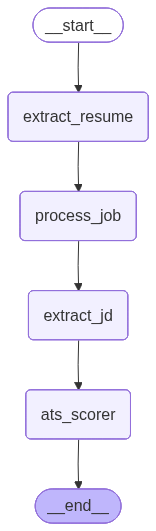

In [50]:
# --------------------------------------------------
# VISUALIZE: Show the Agent's Flow Chart
# --------------------------------------------------
from IPython.display import Image, display

# Generate the Mermaid diagram
# 'app' is the compiled graph variable from the previous step
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This usually happens if you are missing the 'graphviz' or 'pygraphviz' dependency
    print("Could not generate image. Here is the Mermaid syntax instead:")
    print(app.get_graph().draw_mermaid())

In [63]:
# --------------------------------------------------
# TEST PARAMETERS
# --------------------------------------------------
resume_filename = "ML Resume.pdf" 

job_input_data = """
URL: https://www.capitalonecareers.com/job/-/-/234/86216418272?clickid=ae069bff5b0da72679098914c4d8dda0-247-553-3489038240-0&p_sid=8sDDFUb&p_uid=XVNUrY44ua&source=rd_tmp_programmatic_job_tm&ss=paid&utm_campaign=enterprise_tech_pa&utm_content=pj_board&utm_medium=jobad&utm_source=cmp

In this role, you will:
- Partner with a cross-functional team of engineers, research scientists, technical program managers, and product managers to deliver AI-powered products.
- Design, develop, test, deploy, and support AI software components including foundation model training, large language model inference, similarity search, guardrails, model evaluation, experimentation, governance, and observability, etc.
- Leverage a broad stack of Open Source and SaaS AI technologies such as AWS Ultraclusters, Huggingface, VectorDBs, Nemo Guardrails, PyTorch, and more.
- Invent and introduce state-of-the-art LLM optimization techniques to improve the performance - scalability, cost, latency, throughput - of large scale production AI systems.
- Contribute to the technical vision and the long term roadmap of foundational AI systems at Capital One.

The Ideal Candidate:
- You love to build systems, take pride in the quality of your work, and also share our passion to do the right thing. 
- Passion for staying abreast of the latest research, and an ability to intuitively understand scientific publications and judiciously apply novel techniques in production.
- You adapt quickly and thrive on bringing clarity to big, undefined problems. 
- You are deeply Technical. You possess a strong foundation in engineering and mathematics.
- You are a resilient trail blazer who can forge new paths to achieve business goals when the route is unknown.

Basic Qualifications:
- Bachelor's degree in Computer Science, AI, Electrical Engineering, or related fields plus at least 4 years of experience.
- At least 4 years of experience programming with Python, Go, Scala, or Java.

Preferred Qualifications:
- 6 years of experience deploying scalable and responsible AI solutions on cloud platforms (AWS, Google Cloud, Azure).
- Experience developing AI and ML algorithms (e.g. LLM Inference, Similarity Search and VectorDBs, Guardrails, Memory).
- Experience with techniques for optimizing training and inference software to improve hardware utilization, latency, throughput, and cost.
"""

print(f"Starting Analysis...\n")
inputs = {
    "resume_path": resume_filename,
    "job_input": job_input_data
}

# 1. Run Async
result = await app.ainvoke(inputs)

# 2. Process Data
data_for_df = result.copy()

if data_for_df.get("analysis_report"):
    report = data_for_df.pop("analysis_report")
    if isinstance(report, dict):
        data_for_df.update(report)

# 3. Create DataFrame
df = pd.DataFrame([data_for_df])

# 4. Transpose
df_vert = df.T

# 5. Styling
# Ensure we send the full text to HTML (no "..." truncation)
pd.set_option('display.max_colwidth', None)

# Apply CSS to wrap text
styled_df = df_vert.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',       # <--- THIS fixes the horizontal scroll (wraps text)
    'word-wrap': 'break-word',       # <--- Breaks very long urls/words
    'max-width': '1000px',           # <--- Sets a reasonable maximum width
}).set_table_styles([dict(selector='th', props=[('text-align', 'left'), ('vertical-align', 'top')])])

print("\n" + "="*60)
print("FINAL AGENT OUTPUT (WRAPPED TEXT)")
print("="*60)

display(styled_df)

Starting Analysis...

1️⃣ NODE: Extract Resume Text
2️⃣ NODE: Process Job Input
   🔗 Detected URL: https://www.capitalonecareers.com/job/-/-/234/86216418272?clickid=ae069bff5b0da72679098914c4d8dda0-247-553-3489038240-0&p_sid=8sDDFUb&p_uid=XVNUrY44ua&source=rd_tmp_programmatic_job_tm&ss=paid&utm_campaign=enterprise_tech_pa&utm_content=pj_board&utm_medium=jobad&utm_source=cmp
   🕷️ Scraping webpage...

🔍 Starting scrape for: https://www.capitalonecareers.com/job/-/-/234/86216418272?clickid=ae069bff5b0da72679098914c4d8dda0-247-553-3489038240-0&p_sid=8sDDFUb&p_uid=XVNUrY44ua&source=rd_tmp_programmatic_job_tm&ss=paid&utm_campaign=enterprise_tech_pa&utm_content=pj_board&utm_medium=jobad&utm_source=cmp
⚡ Success: Used Fast Static Scrape (BeautifulSoup)
3️⃣ NODE: Finalize Job Description
   -> Merging User Context + Scraped Data...
4️⃣ NODE: ATS Analysis

FINAL AGENT OUTPUT (WRAPPED TEXT)
